    #### INITIAL DISTRIBUTION: TWO MODES ####
    θ_v_1 = 1000.0
    N_1   = 10.0
    k_1   = 4
    θ_v_2 = 200.0
    N_2   = 100.0
    k_2   = 2

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma, Exponential, Sum
from PySDM.dynamics.collisions.collision_kernels import ConstantK, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.dv = 1 * si.m**3

        self.n_part1 = 10 / si.cm**3
        self.k1 = 4
        self.theta1 = 1000 * si.um**3
        self.n_part2 = 100 / si.cm**3
        self.k2 = 2
        self.theta2 = 200 * si.um**3
        
        self.norm_factor1 = self.n_part1 * self.dv
        self.norm_factor2 = self.n_part2 * self.dv
        self.spectrum1 = Gamma(norm_factor=self.norm_factor1, theta=self.theta1, k=self.k1)
        self.spectrum2 = Gamma(norm_factor=self.norm_factor2, theta=self.theta2, k=self.k2)
        self.spectrum = Sum((self.spectrum1, self.spectrum2))

        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 4*3600.0]
        self.kernel = ConstantK(a=1e-4 * si.cm**3 / si.s)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

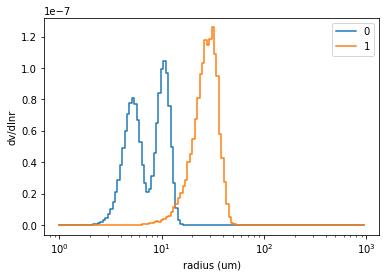

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


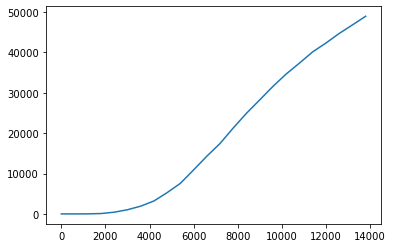

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# constant_bimodal
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [14400.0, 32, 5.0, 1, 7.091336e-10, 1e-09, 0.0001, 4, 1000, 10]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [8.97861677e-003, 7.14479261e-002, 5.65535701e-001, 4.42905267e+000,
 3.39564697e+001, 2.49491685e+002, 1.68358081e+003, 9.58306636e+003,
 3.88146017e+004, 7.97023963e+004, 4.43805294e+004, 2.92153418e+004,
 1.00619543e+005, 4.12711389e+004, 2.16983420e+002, 1.87428989e-004,
 4.37025938e-018, 7.42502868e-047, 6.69776647e-106, 1.70311414e-225,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr36 = [1.84358918e-05, 1.46705746e-04, 1.16127419e-03, 9.09616678e-03,
 6.97867709e-02, 5.14272802e-01, 3.51543819e+00, 2.11616991e+01,
 1.07006770e+02, 4.63242257e+02, 1.60267977e+03, 3.92748413e+03,
 1.36891289e+04, 4.57836311e+04, 1.04975601e+05, 1.23382652e+05,
 4.78880746e+04, 3.88980805e+03, 4.10877067e+01, 3.70904656e-02,
 2.83206574e-06, 2.01333104e-11, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr144 = [1.15125824e-06, 9.16127288e-06, 7.25177026e-05, 5.68028465e-04,
 4.35807716e-03, 3.21187394e-02, 2.19649270e-01, 1.32453050e+00,
 6.73923986e+00, 2.97268248e+01, 1.08216744e+02, 2.89346340e+02,
 1.10336429e+03, 4.52363164e+03, 1.65848286e+04, 5.14043059e+04,
 1.11227477e+05, 1.18340864e+05, 3.95118074e+04, 2.62236340e+03,
 2.14382715e+01, 1.45888433e-02, 8.63963633e-07, 4.95803516e-12,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,  1700.,
  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,  2500.,  2600.,
  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,  3300.,  3400.,  3500.,
  3600.,  3700.,  3800.,  3900.,  4000.,  4100.,  4200.,  4300.,  4400.,
  4500.,  4600.,  4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,
  5400.,  5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
  6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
  7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
  8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,  8900.,
  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,  9700.,  9800.,
  9900., 10000., 10100., 10200., 10300., 10400., 10500., 10600., 10700.,
 10800., 10900., 11000., 11100., 11200., 11300., 11400., 11500., 11600.,
 11700., 11800., 11900., 12000., 12100., 12200., 12300., 12400., 12500.,
 12600., 12700., 12800., 12900., 13000., 13100., 13200., 13300., 13400.,
 13500., 13600., 13700., 13800., 13900., 14000., 14100., 14200., 14300.,
 14400.]
M0_bott = [109.98399358,  71.4476478 ,  52.88613556,  41.97324376,  34.79359362,
  29.71321969,  25.92951061,  23.00243068,  20.67068956,  18.76940397,
  17.18941067,  15.85557181,  14.71448056,  13.72713687,  12.86439784,
  12.10404931,  11.42886275,  10.82527102,  10.28244489,   9.7916355 ,
   9.34569762,   8.93873822,   8.56585358,   8.22292996,   7.90649065,
   7.61357715,   7.34165609,   7.08854547,   6.85235577,   6.63144251,
   6.42436778,   6.22986876,   6.04683188,   5.87427137,   5.71131145,
   5.55717139,   5.41115298,   5.27262985,   5.14103852,   5.01587063,
   4.89666643,   4.78300904,   4.67451959,   4.570853  ,   4.47169424,
   4.37675519,   4.28577178,   4.19850153,   4.11472141,   4.03422593,
   3.9568254 ,   3.8823445 ,   3.8106209 ,   3.7415041 ,   3.67485436,
   3.61054177,   3.54844537,   3.48845243,   3.43045773,   3.37436297,
   3.32007618,   3.26751124,   3.21658743,   3.16722899,   3.11936476,
   3.07292783,   3.02785523,   2.98408764,   2.94156912,   2.90024692,
   2.86007119,   2.82099482,   2.78297325,   2.7459643 ,   2.70992801,
   2.6748265 ,   2.64062383,   2.60728587,   2.57478022,   2.54307607,
   2.5121441 ,   2.48195642,   2.45248646,   2.42370891,   2.39559963,
   2.36813559,   2.34129481,   2.3150563 ,   2.28939999,   2.2643067 ,
   2.2397581 ,   2.21573662,   2.19222545,   2.1692085 ,   2.14667034,
   2.12459616,   2.10297177,   2.08178357,   2.06101848,   2.04066393,
   2.02070787,   2.0011387 ,   1.98194527,   1.96311686,   1.94464315,
   1.9265142 ,   1.90872044,   1.89125266,   1.87410197,   1.85725982,
   1.84071794,   1.82446838,   1.80850346,   1.79281574,   1.77739807,
   1.76224354,   1.74734545,   1.73269736,   1.71829301,   1.70412637,
   1.69019161,   1.67648306,   1.66299527,   1.64972294,   1.63666095,
   1.62380433,   1.61114827,   1.59868812,   1.58641935,   1.5743376 ,
   1.56243861,   1.55071827,   1.53917257,   1.52779765,   1.51658974,
   1.50554519,   1.49466044,   1.48393206,   1.4733567 ,   1.4629311 ,
   1.4526521 ,   1.44251664,   1.43252172,   1.42266444,   1.41294197]
M1_bott = [79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049]
M2_bott = [2.23930994e+08, 2.86237416e+08, 3.48592616e+08, 4.10726236e+08,
 4.72631461e+08, 5.34343782e+08, 5.95898035e+08, 6.57324195e+08,
 7.18647765e+08, 7.79889766e+08, 8.41066694e+08, 9.02190885e+08,
 9.63271278e+08, 1.02431432e+09, 1.08532482e+09, 1.14630661e+09,
 1.20726294e+09, 1.26819680e+09, 1.32911096e+09, 1.39000801e+09,
 1.45089035e+09, 1.51176012e+09, 1.57261919e+09, 1.63346913e+09,
 1.69431123e+09, 1.75514651e+09, 1.81597575e+09, 1.87679950e+09,
 1.93761819e+09, 1.99843209e+09, 2.05924139e+09, 2.12004625e+09,
 2.18084678e+09, 2.24164309e+09, 2.30243529e+09, 2.36322351e+09,
 2.42400792e+09, 2.48478870e+09, 2.54556604e+09, 2.60634018e+09,
 2.66711136e+09, 2.72787982e+09, 2.78864583e+09, 2.84940963e+09,
 2.91017147e+09, 2.97093160e+09, 3.03169025e+09, 3.09244760e+09,
 3.15320386e+09, 3.21395919e+09, 3.27471373e+09, 3.33546761e+09,
 3.39622091e+09, 3.45697373e+09, 3.51772612e+09, 3.57847812e+09,
 3.63922975e+09, 3.69998102e+09, 3.76073192e+09, 3.82148245e+09,
 3.88223257e+09, 3.94298225e+09, 4.00373147e+09, 4.06448017e+09,
 4.12522832e+09, 4.18597588e+09, 4.24672280e+09, 4.30746905e+09,
 4.36821459e+09, 4.42895939e+09, 4.48970342e+09, 4.55044666e+09,
 4.61118909e+09, 4.67193070e+09, 4.73267149e+09, 4.79341144e+09,
 4.85415056e+09, 4.91488886e+09, 4.97562636e+09, 5.03636308e+09,
 5.09709902e+09, 5.15783423e+09, 5.21856873e+09, 5.27930256e+09,
 5.34003574e+09, 5.40076832e+09, 5.46150033e+09, 5.52223182e+09,
 5.58296282e+09, 5.64369338e+09, 5.70442354e+09, 5.76515335e+09,
 5.82588283e+09, 5.88661204e+09, 5.94734101e+09, 6.00806979e+09,
 6.06879840e+09, 6.12952689e+09, 6.19025528e+09, 6.25098360e+09,
 6.31171189e+09, 6.37244018e+09, 6.43316848e+09, 6.49389682e+09,
 6.55462521e+09, 6.61535369e+09, 6.67608225e+09, 6.73681091e+09,
 6.79753969e+09, 6.85826859e+09, 6.91899762e+09, 6.97972677e+09,
 7.04045606e+09, 7.10118549e+09, 7.16191504e+09, 7.22264472e+09,
 7.28337453e+09, 7.34410445e+09, 7.40483448e+09, 7.46556461e+09,
 7.52629483e+09, 7.58702513e+09, 7.64775549e+09, 7.70848591e+09,
 7.76921636e+09, 7.82994685e+09, 7.89067734e+09, 7.95140783e+09,
 8.01213830e+09, 8.07286874e+09, 8.13359913e+09, 8.19432945e+09,
 8.25505970e+09, 8.31578985e+09, 8.37651990e+09, 8.43724982e+09,
 8.49797960e+09, 8.55870923e+09, 8.61943870e+09, 8.68016800e+09,
 8.74089710e+09, 8.80162601e+09, 8.86235471e+09, 8.92308318e+09,
 8.98381143e+09]
mprecip_bin = [1.71554590e-47, 4.09238708e-08, 3.10195563e-06, 4.83008229e-05,
 3.73686563e-04, 1.91729114e-03, 7.46067097e-03, 2.37314925e-02,
 6.46742485e-02, 1.55894090e-01, 3.40044073e-01, 6.82731725e-01,
 1.27841256e+00, 2.25572786e+00, 3.78181610e+00, 6.06525288e+00,
 9.35742177e+00, 1.39522626e+01, 2.01844674e+01, 2.84262882e+01,
 3.90831838e+01, 5.25885662e+01, 6.93979167e+01, 8.99825307e+01,
 1.14823129e+02, 1.44403543e+02, 1.79204639e+02, 2.19698633e+02,
 2.66343870e+02, 3.19580172e+02, 3.79824763e+02, 4.47468816e+02,
 5.22874603e+02, 6.06373243e+02, 6.98263013e+02, 7.98808183e+02,
 9.08238342e+02, 1.02674815e+03, 1.15449751e+03, 1.29161203e+03,
 1.43818382e+03, 1.59427252e+03, 1.75990656e+03, 1.93508452e+03,
 2.11977673e+03, 2.31392681e+03, 2.51745348e+03, 2.73025220e+03,
 2.95219697e+03, 3.18314211e+03, 3.42292397e+03, 3.67136265e+03,
 3.92826363e+03, 4.19341946e+03, 4.46661122e+03, 4.74761006e+03,
 5.03617860e+03, 5.33207225e+03, 5.63504049e+03, 5.94482804e+03,
 6.26117598e+03, 6.58382278e+03, 6.91250524e+03, 7.24695939e+03,
 7.58692129e+03, 7.93212778e+03, 8.28231718e+03, 8.63722985e+03,
 8.99660880e+03, 9.36020016e+03, 9.72775365e+03, 1.00990230e+04,
 1.04737661e+04, 1.08517456e+04, 1.12327291e+04, 1.16164892e+04,
 1.20028037e+04, 1.23914562e+04, 1.27822356e+04, 1.31749365e+04,
 1.35693594e+04, 1.39653104e+04, 1.43626018e+04, 1.47610514e+04,
 1.51604830e+04, 1.55607261e+04, 1.59616161e+04, 1.63629942e+04,
 1.67647070e+04, 1.71666070e+04, 1.75685521e+04, 1.79704054e+04,
 1.83720357e+04, 1.87733168e+04, 1.91741278e+04, 1.95743526e+04,
 1.99738801e+04, 2.03726042e+04, 2.07704231e+04, 2.11672398e+04,
 2.15629617e+04, 2.19575004e+04, 2.23507718e+04, 2.27426959e+04,
 2.31331965e+04, 2.35222014e+04, 2.39096421e+04, 2.42954535e+04,
 2.46795741e+04, 2.50619459e+04, 2.54425139e+04, 2.58212264e+04,
 2.61980348e+04, 2.65728933e+04, 2.69457589e+04, 2.73165913e+04,
 2.76853531e+04, 2.80520092e+04, 2.84165268e+04, 2.87788758e+04,
 2.91390280e+04, 2.94969576e+04, 2.98526407e+04, 3.02060557e+04,
 3.05571825e+04, 3.09060032e+04, 3.12525014e+04, 3.15966625e+04,
 3.19384736e+04, 3.22779233e+04, 3.26150016e+04, 3.29496999e+04,
 3.32820113e+04, 3.36119297e+04, 3.39394505e+04, 3.42645705e+04,
 3.45872871e+04, 3.49075993e+04, 3.52255069e+04, 3.55410106e+04,
 3.58541122e+04, 3.61648144e+04, 3.64731205e+04, 3.67790349e+04,
 3.70825626e+04]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr144) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.0, 105.3779757505876, 0.001228498822910961, 0.00032239470810806886, 0.0007031987720132858, 0.00021949775901025553, 5.268553865589344e-5, 3.5808625294069276e-5]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 0.0361798608682308, 0.02023422074890235, 0.5247260919234045, 0.7586394394022978, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [0.0, 13.557564545039192, 35.48293522152489, 54.334589421965106, 3.7538389358707775e-7, 8.128957568491646, 0.49558793735398804, 4.247610703088978e-6, 5.8983956558722425e-6, 5.947718337922552e-6, 5.185257774273789e-6, 3.4040766897221995e-6, 1.6963320561831901e-6, 6.972178630826224e-7, 3.0913281255195515e-7, 3.6896604493650604e-7]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_final = [0.0, 0.0025004068146930424, 0.005591683770451627, 0.016539954441943852, 0.03405051779667789, 0.06845327602783854, 0.1516964109533709, 0.31212184274383215, 0.5097190041795672, 0.25153476668082686, 0.0, 0.0, 2.6898398615331063e-5, 0.0, 0.0, 1.6231067920845886e-10]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# GAMMA CASE
# initial moments: 110.0, 8e4, 2.24e8
# k theta = 727; k(k+1)*theta^2 = 2e6; (k+1)*theta = 2750; 727(k+1) = 2750 k;
# initial N, k, theta = 110.0, 2.78, 261.5
# final N, k, theta = 1.3715710848997096, 0.9774527473508617, 59672.728272908156, 
def mom_f(x):
    n = 1.3715710848997096
    k = 0.9774527473508617
    theta = 59672.728272908156
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =110.0
    k =2.78
    theta = 261.5
    return n*gamma.pdf(x, k, scale=theta)

In [12]:
col_8_times = [0.0, 0.3016369915755026, 0.8609400378972863, 6.453970501115124, 32.64498130008926, 75.46215975951601, 128.50236258591227, 199.3333006075369, 286.59646172334374, 393.96567465156, 474.5510448539667, 612.415458519055, 768.9060989305276, 1006.7225774916783, 1308.386922148632, 1685.8852563686562, 2170.3058298057044, 2792.4080101135173, 3592.4504920915033, 4590.370512055187, 5641.406915459243, 7302.581553687587, 8977.480663846687, 11327.729044926247, 14144.591012520019, 14400.0]
col_8_M_0 = [94.10107364754086, 93.99249530633621, 93.79281464612467, 91.83357202016754, 83.4906633129369, 72.28501357561194, 61.51286167381418, 50.82300181568959, 41.44288619841685, 33.949705657013425, 30.00903307935007, 25.010491959537248, 21.005545111562302, 16.853198170493663, 13.422621235303042, 10.642933979342688, 8.355637469115232, 6.502174013161612, 5.022078118662633, 4.028359440419825, 3.336732491589219, 2.6200117350493968, 2.147546872106913, 1.7060054520765242, 1.3608153357682695, 1.335906994172208]
col_8_M_1 = [79792.6731604243, 79891.90561325177, 80110.8146186503, 82196.14998469858, 89743.93195929435, 96180.23578797905, 97926.85784427341, 94934.14704331213, 88124.01892491605, 97563.8146560678, 110030.88940493007, 126306.18900374863, 137871.4735778209, 145418.57345872652, 144977.77164194442, 137538.0988065033, 124886.66637620854, 109256.64899602676, 92734.79164958953, 118124.87288501622, 137031.0687536338, 151039.35800661196, 153813.6224054397, 148802.6375791439, 137866.10258173972, 136793.26590345963]
col_8_M_2 = [1.192564900110947e10, 9.451701727559244e9, 9.421361145041626e9, 9.129480307558933e9, 7.99748420593235e9, 6.724004319769537e9, 5.718477244494396e9, 4.891642409517675e9, 4.283473139036005e9, 2.102307122713145e10, 2.211852841625265e10, 2.362089068838246e10, 2.4808064901353195e10, 2.5848437976446194e10, 2.6380194589367554e10, 2.645149228517471e10, 2.617906448738308e10, 2.569116670807228e10, 2.5109058625902477e10, 2.5362146242319893e10, 3.9994758039185524e10, 5.296639809506947e10, 5.854505593698997e10, 6.0057937269468796e10, 5.7737308447595375e10, 5.742662948838213e10]

col_16_times = [0.0, 0.2821300345992729, 1.2742003523626189, 11.194903529996079, 37.52504788402559, 77.40984201686021, 122.23731360474306, 181.62844880891967, 254.54601572892153, 351.9577033232853, 480.5018329254359, 628.8092381800009, 819.4662940743901, 1004.6800828076907, 1306.644486278938, 1630.6696108191204, 2093.9135782993367, 2645.295475346489, 2979.0264195217082, 3790.4955494487135, 4563.408172632918, 5836.288993214459, 7082.314862138459, 8206.586817084848, 10007.975946972318, 12204.292867878752, 14400.0]
col_16_M_0 = [108.76984873610354, 108.60644179258122, 108.03567841474005, 102.63653325286354, 90.58430011151161, 76.8471455681106, 65.61039935563826, 54.92877880434958, 45.757178079367755, 37.39405968489533, 30.097923012412753, 24.519407591306386, 19.86371044611624, 16.77939973066117, 13.385948507173088, 10.982873337432958, 8.707056882281279, 6.967710452380019, 6.2442245738103335, 4.984220216527835, 4.174477763013785, 3.2786748213801924, 2.6957873279333335, 2.3417743243113276, 1.9347878314195432, 1.593897583452267, 1.3516390907308653]
col_16_M_1 = [79939.94454089293, 79960.39285204874, 80032.20800672275, 80678.97678709502, 81861.20806973467, 82656.72620101116, 82840.24344696144, 82711.2481947248, 82474.63794676751, 82108.32553531749, 81193.15411449049, 79265.02402245786, 80407.89315175053, 81872.06043383216, 83303.0061763604, 83190.16313444798, 80700.6486995659, 77617.15944936806, 79110.05602300997, 81459.94611713955, 81822.69721392698, 79473.73186407976, 75459.44406199171, 77259.80815673585, 79419.42364098273, 79992.92170464744, 78777.54139460335]
col_16_M_2 = [4.740924439818351e8, 4.732312818692744e8, 4.7282800458951557e8, 4.6941856643830395e8, 4.6357701167059875e8, 4.6489706805879885e8, 4.730565517736225e8, 4.86546590348162e8, 5.147192624739326e8, 5.619718332002692e8, 6.226311278776906e8, 6.767414881741436e8, 8.552648620028012e8, 1.0628916942138627e9, 1.3571089822262504e9, 1.587901543374548e9, 1.7830795127938387e9, 1.9586346306627336e9, 2.380777291880793e9, 3.255632422520712e9, 3.850470270309739e9, 4.415407866054531e9, 4.570886064359334e9, 5.843113756541406e9, 7.750348334042862e9, 9.428465654558746e9, 1.048719224631113e10]


In [13]:
t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [1004.6119111129144, 843.3434716469906, 825.5716756666375, 11902.074413737177, 22961.495079700875, 30871.16904208533, 36212.340348164515, 39639.46577942981, 41689.73753389563, 42766.12942011946, 43160.67647414998, 43081.41727173064, 42677.55175511715, 42053.69950041505, 41284.59520513775, 40424.33719330083, 39510.33736771361, 38569.02604038946, 37619.76690808746, 36676.32850910929, 35747.567443903165, 34839.691915280964, 33956.71385122982, 33101.440764138555, 32275.504822256808, 30974.907056063632, 36763.17072396406, 42789.61441672765, 48499.68400071586, 53902.30053249234, 59007.41158543652, 63825.99124974375, 68369.92518131563, 72650.74033167942, 76679.96799988259, 80468.99370654293, 84028.93201611505, 87370.62653689104, 90504.64992099989, 93441.30393621558, 96190.54257774558, 98761.80191665675, 101164.12661780354, 103406.19906297378, 105496.33935088813, 107442.50529720068, 109252.29243449894, 110932.93401230327, 112491.30099706721, 113933.90207217787, 115266.88363795531, 116496.12601804186, 117627.2872824496, 118665.58612614307, 119616.00988382113, 120483.32098102776, 121272.05693415218, 121986.5303504282, 122630.82892793507, 123208.81545559705, 123724.12781318331, 124180.17897130815, 124580.17161179266, 124927.33305983973, 125224.55659927572, 125474.52680147217, 125679.82075234155, 125842.90805233759, 125966.15081645551, 126051.80367423139, 126102.01376974252, 126118.82076160781, 126104.15682298678, 126059.84664158047, 125987.60741963133, 125889.04887392267, 125765.67323577926, 125618.8752510666, 125449.94469109147, 125260.27850679134, 125051.15382968851, 124823.67951299335, 124578.92349143024, 124317.91278123771, 124041.63348016822, 123751.03076748837, 123447.0089039788, 123130.43123193429, 122802.1201751635, 122462.8572389893, 122113.38301024864, 121754.39715729246, 121386.55842998566, 121010.48465970761, 120626.75275935126, 120235.89872332374, 119838.4176275465, 119434.76362945493, 119025.3874441799, 118610.79270007198]
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [23.164628741239973, 14.606477511555871, 25.726616382623835, 49.93499068249179, 88.71760948193212, 109.95346335353419, 320.8052389633221, 546.8479733367667, 770.2055490991337, 980.0506863287765, 1171.0003584454892, 1341.1385762871728, 1490.595038788505, 1620.67227050459, 1733.081033902744, 1831.540792162459, 1916.222885611609, 1984.5242030743912, 2899.4224621047415, 4359.72208637405, 5818.779389975335, 7258.976510778592, 8666.817836099483, 10031.929326325926, 11346.198432681826, 12603.775717612676, 13800.963983412761, 14935.731478157413, 16007.003124134142, 17014.737215438363, 17959.525907084506, 18842.593816530993, 19665.707848821155, 20430.857089330788, 21140.416401035698, 21796.808904292455, 22402.47540768449, 22959.87440802135, 23471.482090339432, 23939.792327901465, 24367.316682196877, 24756.64594876385, 25110.039351127332, 25429.42290920295, 25716.760616346408, 25974.057412077043, 26203.359182078293, 26406.75275819739, 26586.35257804119, 27015.621436641435, 27949.975805062684, 28931.805246657717, 29897.886111886208, 30847.304098830395, 31779.266501347895, 32693.102209070123, 33588.26170740383, 34464.29611769516, 35320.79027111949, 36157.4694759127, 36974.116947818184, 37770.56283320794, 38546.68420908389, 39302.40508307725, 40037.720074082674, 40753.13948926031, 41448.33897012014, 42123.37123507603, 42778.39694014001, 43413.621235576225, 44029.213486050285, 44625.39278431906, 45202.42321103793, 45760.577118255256, 46300.135129413655, 46821.386139350594, 47324.62731429733, 47810.164091879364, 48278.3101811166, 48729.38756242285, 49163.72648760649, 49581.6654798697, 49983.55133380929, 50369.739115415956, 50740.591935275035, 51096.447485346565, 51437.640276044825, 51764.51867188739, 52077.426931496055, 52376.70520759758, 52662.68954702337, 52935.711890709004, 53196.10007369511, 53444.177825126884, 53680.26476825346, 53904.676420429736, 54117.72419311409, 54319.71539187008, 54510.95321636598, 54691.73676037407]


In [14]:
t_cloudy = [0.0, 0.030894546206486816, 0.3398400082713549, 2.7188300686039506, 7.153018272609508, 12.589396108658308, 19.36683382356473, 27.32609752414269, 36.575071830755476, 47.051065738494735, 58.78326554447952, 71.75496131840438, 85.98329613645913, 101.47990277715317, 118.27339333835471, 136.39783424717382, 155.8986450774671, 176.8301089272111, 199.25595081788668, 223.24850390791357, 248.88918913073292, 276.2681452388591, 305.48440800861187, 336.6459583401506, 369.86994785745947, 405.282955262956, 443.02135154929704, 483.2317144667684, 526.0713453486346, 571.7088077501586, 620.324600377322, 672.1118378102101, 727.2770624630233, 786.0410910413843, 848.6399434477947, 915.3258721441409, 986.3684738314196, 1062.0558890232896, 1142.6961002381865, 1228.6183291585291, 1320.1745812694176, 1417.7412885332103, 1521.721058885124, 1632.5446609527694, 1750.6730709364554, 1876.5997419626042, 2010.8530689053378, 2153.9990590211346, 2306.6441842262698, 2469.438522126158, 2643.0791797542033, 2828.3140045846735, 3025.9455789913827, 3236.8356618889597, 3461.9099131114885, 3702.1631972729792, 3958.6652118608545, 4232.566807502979, 4525.1067136424645, 4837.61909378266, 5171.54172666395, 5528.424897526699, 5909.9414297795365, 6317.897317472517, 6754.243793796419, 7221.090391996653, 7720.71938821372, 8255.6017635376, 8828.41491046852, 9442.061875730207, 10099.69295933413, 10804.72960487433, 11560.890680515251, 12372.22165992211, 13243.127314718635, 14178.407579244484, 14400.0]
M0_cloudy = [110.0, 109.98131197501435, 109.79478037511034, 108.3793424176081, 105.83623319535847, 102.87664819110962, 99.41098215709661, 95.6277650219083, 91.5779204130947, 87.38613953717228, 83.12501950432764, 78.87270615563388, 74.68218683430734, 70.59701813341171, 66.64632290899125, 62.85038783627419, 59.22121267947147, 55.76493894692083, 52.483226569063476, 49.37458634206006, 46.43523980209834, 43.65989307908189, 41.04226097589539, 38.57547421738962, 36.25236614804963, 34.065681052787674, 32.008218139670554, 30.072931674148233, 28.25299616349009, 26.54184969645861, 24.93321706209133, 23.42112309823464, 21.999895210476623, 20.664161283275412, 19.40884314139943, 18.229146890840337, 17.120551776755207, 16.07879816335773, 15.099875025312336, 14.18000737723219, 13.315643473550626, 12.503442670367265, 11.740263834063743, 11.023153510495234, 10.349335404792281, 9.716199957468485, 9.121294466158087, 8.562313779273403, 8.037091668222427, 7.543592486059166, 7.079903299912793, 6.644226537305276, 6.234873153562933, 5.850255998739982, 5.488883812732447, 5.149355315501531, 4.8303539127151405, 4.5306424815724675, 4.249058697188346, 3.9845104276363124, 3.735971522339359, 3.502477896376976, 3.2831236695043677, 3.077057784047998, 2.883480603680887, 2.701640844894343, 2.5308326595374706, 2.3703928815211937, 2.2196984221647713, 2.0781639068739333, 1.9452393628212412, 1.820408063634154, 1.7031845392887857, 1.5931126901826622, 1.4897639764165618, 1.3927357772734232, 1.3715710848997096]
M1_cloudy = [80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0]
M2_cloudy = [2.24e8, 2.240197725095723e8, 2.242174976052952e8, 2.2574005124391887e8, 2.2857793169450292e8, 2.3205721350959998e8, 2.3639477364717337e8, 2.414887024155839e8, 2.4740804597186545e8, 2.5411268207287735e8, 2.616212899487771e8, 2.699231752441705e8, 2.7902930952782077e8, 2.889471377779758e8, 2.9969497173727363e8, 3.112946139190674e8, 3.237751328506287e8, 3.3717126971466625e8, 3.515238085249326e8, 3.668790425028218e8, 3.8328908104574263e8, 4.008116129553121e8, 4.1951002112838376e8, 4.394534133410707e8, 4.6071676663273555e8, 4.833810913729409e8, 5.075336649970052e8, 5.3326829726513326e8, 5.606856610306402e8, 5.898936369689252e8, 6.210077442518532e8, 6.54151576210723e8, 6.894573199906753e8, 7.270662982833717e8, 7.671295638264884e8, 8.09808558195723e8, 8.552758232798218e8, 9.037157690076561e8, 9.553255041911803e8, 1.0103157307073298e9, 1.0689117320667933e9, 1.1313544247257514e9, 1.1979014777630677e9, 1.2688285831008055e9, 1.3444307655076349e9, 1.4250238349850354e9, 1.5109459642531328e9, 1.6025593979569032e9, 1.700252278123764e9, 1.804440654422393e9, 1.9155706753556337e9, 2.0341209633087919e9, 2.160605171003257e9, 2.295574824146994e9, 2.4396223450369763e9, 2.5933844470300035e9, 2.7575457365226817e9, 2.932842757922505e9, 3.1200682980799494e9, 3.320076221645541e9, 3.533786707023341e9, 3.76219193677964e9, 4.006362517911165e9, 4.2674542866285305e9, 4.546716032196552e9, 4.845497855920103e9, 5.165260414563184e9, 5.507585136065182e9, 5.874185551677577e9, 6.266919611366666e9, 6.687803507217467e9, 7.139026963225898e9, 7.622970055135325e9, 8.142221886237435e9, 8.699601510551985e9, 9.29818088628008e9, 9.440000037214695e9]
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [5.8939020604571585e-9, 8.762794954110384e-6, 0.0008811564259705533, 0.0208664603742977, 0.2081996513960509, 1.1903536891403592, 4.657650996067146, 13.917886523276959, 34.10842133173563, 71.94895635510971, 135.14102732208323, 231.62109671194673, 368.8555271504873, 553.2935487295254, 790.0197456535701, 1082.5964281717715, 1433.059147152528, 1842.0206483158977, 2308.8414074111993, 2831.832787097715, 3408.4679305249556, 4035.584037757419, 4709.5653543040335, 5426.502710919461, 6182.328236290643, 6972.924638544213, 7794.212000600902, 8642.215619346973, 9513.114455941397, 10403.277651926855, 11309.286978174074, 12227.951476867938, 13156.31323372595, 14091.648508373699, 15031.463188516185, 15973.486548263932, 16915.660821774993, 17856.1313581735, 18793.233768121674, 19725.482178604754, 20651.55652915065, 21570.289940338767, 22480.65710248448, 23381.76227900695, 24272.8283978947, 25153.18664747559, 26022.266555216385, 26879.586927311248, 27724.74726383871, 28557.4199518884, 29377.343041828164, 30184.313420606657, 30978.180794746942, 31758.8422826819, 32526.236939403818, 33280.34123451457, 34021.16506910529, 34748.74773629295, 35463.154270230436, 36164.472402413696, 36852.810091751766, 37528.29247172651, 38191.059550522055, 38841.26416543788, 39479.07052814232, 40104.65207162799, 40718.18984235912, 41319.871257177736, 41909.88920649867, 42488.44086400949, 43055.726195709765, 43611.94753543783, 44157.308622019285, 44692.01440060753, 45216.270001140314, 45730.27991318875, 46234.24798286232, 46728.37675328247, 47212.8675682115, 47687.919879500296, 48153.73065150702, 48610.494653719186, 49058.403866786146, 49497.64784120137, 49928.41335129568, 50350.88392394944, 50765.239875728934, 51171.65840525408, 51570.31339699108, 51961.37573241777, 52345.013004720706, 52721.38922642578, 53090.665023086636, 53452.99773710521, 53808.54127799347, 54157.44649793688, 54499.86102301937, 54835.929079201414, 55165.79139616876, 55489.5857814952]


## Plotting

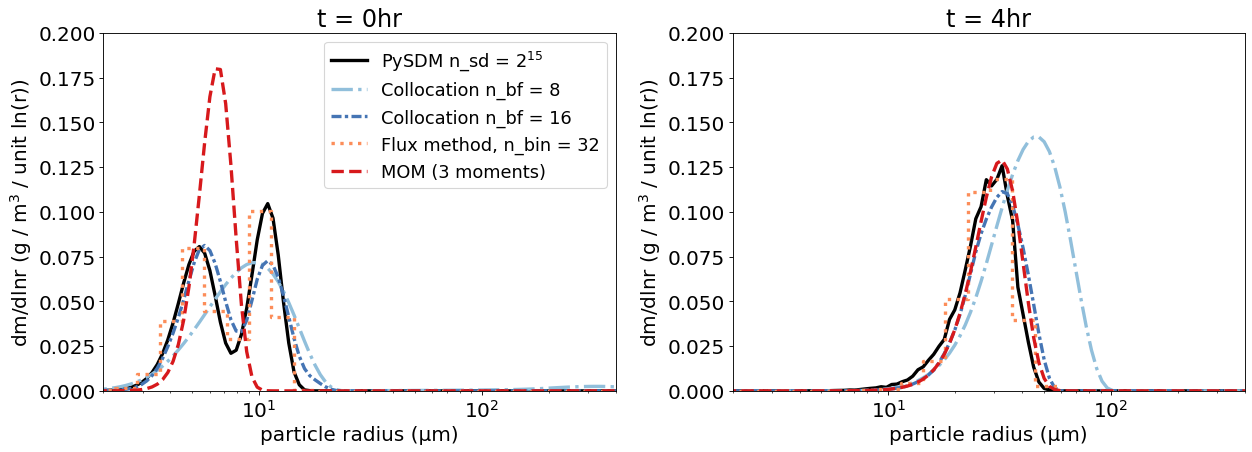

In [15]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],label='Flux method, n_bin = 32', linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],label="MOM (3 moments)",linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (3 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([2.0, 400.0])
ax[1].set_xlim([2.0, 400.0])
ax[0].set_ylim([0.0, 0.2])
ax[1].set_ylim([0.0, 0.2])
ax[0].legend(fontsize=16)

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 4hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.tight_layout()
pyplot.savefig("m(v)_constant_bimodal.pdf", transparent=True)

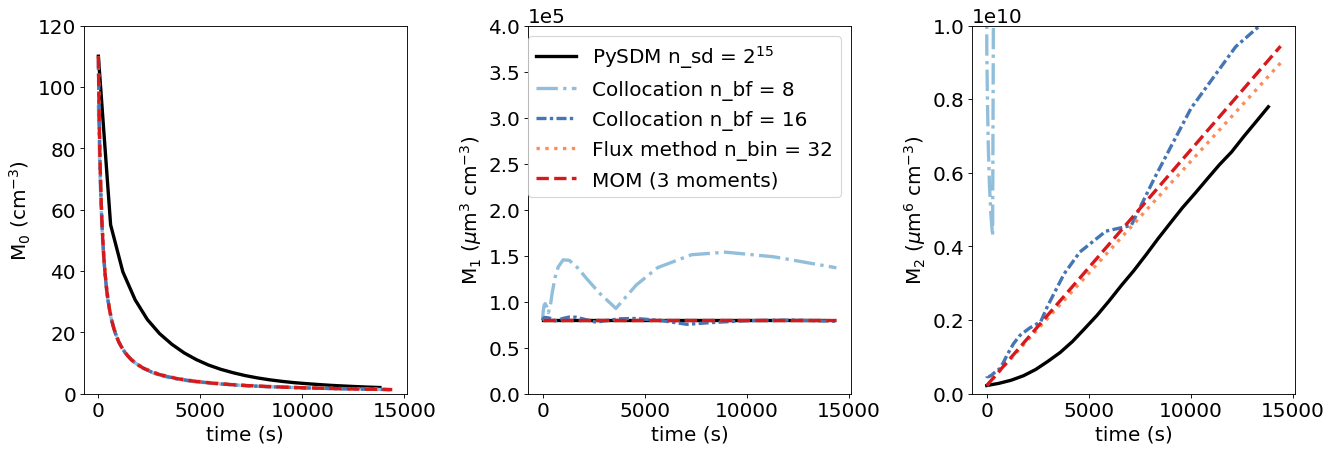

In [16]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 120])
ax[1].set_ylim([0, 4e5])
ax[2].set_ylim([0, 1e10])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_constant_bimodal.pdf", transparent=True)


In [17]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

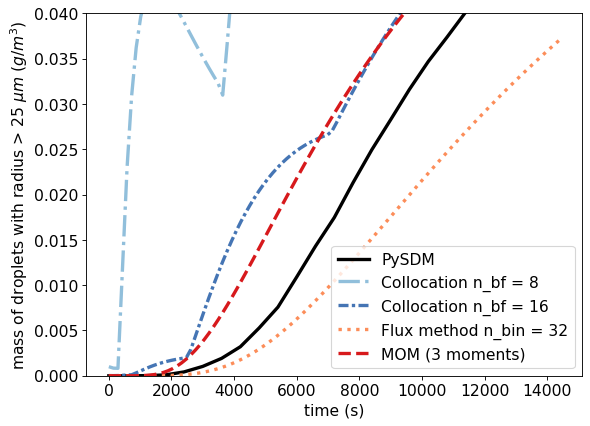

In [18]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (3 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.gca().set_ylim([0.0, 0.04])
pyplot.savefig('m_precip_constant_bimodal.pdf', transparent=True)

## Error Computation

In [20]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("constant_bimodal_errors.pkl", "wb" ))

1.1565732928520174 0.27168043810403286 0.2062021405422877 0.2712382140426423
